### In the best case, 100 episodes 100% more than -500

In [8]:
import torch
import numpy as np
import gym
import quanser_robots
%matplotlib inline 
from matplotlib import pyplot as plt

st_quan = [200,100]
a_quan = [3]

s_len = 2
a_len = 1

## old discretation function
# def state_cont2dis(conti, possible_dis):
#     if conti.ndim == 1 : #single state point
#         conti = conti.reshape(1,-1)
#     assert possible_dis.ndim == 2
#     assert conti.shape[1] == possible_dis.shape[1]
    
#     possible_dis = possible_dis.reshape( 1, possible_dis.shape[0], possible_dis.shape[1])
    
#     conti = conti.reshape(conti.shape[0], 1, conti.shape[1])
    
#     err = np.abs(possible_dis-conti)
#     err = np.sum(err, axis=-1)
    
#     index = np.argmin(err, axis=-1)
#     del err
#     possible_dis = possible_dis.reshape( -1, possible_dis.shape[2])
#     return index, possible_dis[index]

def state_cont2dis(conti, s1_dis, s2_dis, possible_combi):
    if conti.ndim == 1 : #single state point
        conti = conti.reshape(1,-1)
    assert possible_combi.ndim == 2
    assert conti.shape[1] == possible_combi.shape[1]
    
    s1_dis = s1_dis.reshape(1,-1)
    s2_dis = s2_dis.reshape(1,-1)
    s1 = conti[:,0].reshape(-1,1)
    s2 = conti[:,1].reshape(-1,1)
    err1 = np.abs(s1 - s1_dis)
    err2 = np.abs(s2 - s2_dis)
  
    index1 = np.argmin(err1,axis=-1)
    index2 = np.argmin(err2,axis=-1)
    index = index1*s2_dis.shape[1] + index2
    states = possible_combi[index]
    return index, states


reward_model = torch.load(f"dynamics_models/Pendulum_rewards.pth")
state_model= torch.load(f"dynamics_models/Pendulum_states.pth")
reward_model.eval()
state_model.eval()

para = np.load(f"dynamics_models/Data_para.npz")
# print(para.files)
st_mean = para["st_mean"].reshape(1,-1)
st_std = para["st_std"].reshape(1,-1)
r_mean = para["r_mean"]
r_std = para["r_std"]
a_mean = para["a_mean"]
a_std = para["a_std"]

env = gym.make("Pendulum-v2")
a_low, a_high = env.action_space.low, env.action_space.high
s_low, s_high = env.observation_space.low, env.observation_space.high

#-------------
if True: #if not manualy set discretization
    dis_actions = np.linspace(a_low, a_high, a_quan[0], dtype=float)
    dis_states1 = np.linspace(s_low[0], s_high[0], st_quan[0], dtype=float)
    dis_states2 = np.linspace(s_low[1], s_high[1], st_quan[1], dtype=float)
    
#----------------------------------------------
# old state discretezation
# A, B = np.meshgrid(dis_states1, dis_states2)
# possible_states = np.concatenate( [A.reshape(-1,1), B.reshape(-1,1)], axis=-1)
# del A,B,dis_actions

#----------------------------------------
# new state discretezation
possible_states = np.zeros((len(dis_states1), len(dis_states2), s_len ) )
possible_states[:,:,0] = dis_states1.reshape(-1, 1)# Becareful for the shape!!!
possible_states[:,:,1] = dis_states2.reshape( 1, -1)  
possible_states = possible_states.reshape(-1,2)

possible_actions = dis_actions

s_a_pair = np.zeros((len(possible_states), len(possible_actions), s_len + a_len ))
s_a_pair[:, :, :s_len] = possible_states.reshape(-1,1,s_len)
s_a_pair[:, :, s_len:] = possible_actions.reshape(1,-1,a_len)

print("created state action pair: ", s_a_pair.shape)


# get s'(s,a) and r_s_a

inputs = s_a_pair.reshape(-1, s_len+a_len)
del s_a_pair

inputs = np.concatenate( 
    [np.sin(inputs[:,0]).reshape(-1,1), np.cos(inputs[:,0]).reshape(-1,1), inputs[:,1:]], 
    axis = -1)
inputs[:,:3] = (inputs[:,:3] - st_mean)/st_std
inputs[:,3:] = ((inputs[:,3:] - a_mean))/a_std
inputs = torch.tensor(inputs)

r_s_a = reward_model(inputs)
r_s_a = r_s_a.detach().numpy()
r_s_a = r_s_a*r_std + r_mean
r_s_a = r_s_a.reshape(len(possible_states), len(possible_actions))

sne_s_a = state_model(inputs)
sne_s_a = sne_s_a.detach().numpy()
sne_s_a = sne_s_a*st_std + st_mean
sne_s_a = np.stack(
    [ np.arctan2(sne_s_a[:,0],sne_s_a[:,1]), sne_s_a[:,2] ],
    axis=-1)
del inputs, state_model, reward_model

print("finished combining all state action reward nextsate")

#important is index, state not used by the iteration
ne_index, dis_st = state_cont2dis(sne_s_a, dis_states1, dis_states2, possible_states) 
dis_err = np.sum(  np.abs( dis_st- sne_s_a ) )

print("For %d states"%len(possible_states), "discretization error: ", dis_err )

ne_index = ne_index.reshape(len(possible_states), len(possible_actions))


gamma = 1 - 1e-3
v = np.zeros((possible_states.shape[0], 1))
V = np.zeros_like(v)
q = np.zeros_like(r_s_a)

t = 0
while t<50000:
    t+=1
    
    v = V
    q = r_s_a + gamma * V[ne_index].reshape(ne_index.shape)
    assert q.ndim==2
    assert q.shape[0] == len(possible_states)
    assert q.shape[1] == len(possible_actions)
    V = np.max(q, axis=-1)
    assert V.shape[0] == possible_states.shape[0]
    
    err = np.abs(v-V)
    if np.max(err) <1e-7:
        print("succeseful")
        break
    print(t, np.max(err))
policy = possible_actions[np.argmax(q,axis=1)]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
created state action pair:  (20000, 3, 3)
finished combining all state action reward nextsate
For 20000 states discretization error:  3322.0207311159074
1 15.847591601857498
2 15.618322093549136
3 15.595774907250181
4 15.580179132342934
5 15.520143958569982
6 15.504623814611413
7 15.489119190796814
8 15.473630071606024
9 15.458156441534427
10 15.442698285092888
11 15.245518770302738
12 15.018043872280742
13 14.649710463275909
14 14.410552997546773
15 14.197032027476538
16 14.182834995449014
17 13.984023315397408
18 13.811415117502577
19 13.64764420909384
20 13.631914146330047
21 13.489043215494647
22 13.353737288890343
23 13.103691634949541
24 12.993553252890635
25 12.980559699637737
26 12.967579139938096
27 12.954611560798114
28 12.941656949237299
29 12.797147202472772
30 12.784350055270295

374 0.4089875325174148
375 0.4085785449848913
376 0.4081699664399139
377 0.40776179647346567
378 0.40735403467701303
379 0.40694668064233497
380 0.40653973396169363
381 0.40613319422772065
382 0.4057270610335024
383 0.4053213339724664
384 0.40491601263849475
385 0.4045110966258392
386 0.4041065855292345
387 0.4037024789436998
388 0.40329877646473733
389 0.4028954776882756
390 0.40249258221058426
391 0.40209008962838766
392 0.40168799953875123
393 0.40128631153922356
394 0.4008850252276659
395 0.40048414020245104
396 0.40008365606223606
397 0.39968357240618957
398 0.39928388883379284
399 0.3988846049449535
400 0.3984857203400054
401 0.398087234619652
402 0.39768914738505146
403 0.3972914582376461
404 0.39689416677941836
405 0.3964972726126348
406 0.39610077534001675
407 0.3957046745646835
408 0.39530896989012376
409 0.3949136609202242
410 0.3945187472592977
411 0.3941242285120552
412 0.3937301042835486
413 0.39333637417925615
414 0.39294303780508244
415 0.3925500947672731
416 0.39215754

859 0.19897930307138267
860 0.1987803237682897
861 0.19858154344456125
862 0.19838296190107485
863 0.1981845789392196
864 0.19798639436027088
865 0.19778840796590202
866 0.19759061955790003
867 0.19739302893839294
868 0.197195635909452
869 0.1969984402735463
870 0.19680144183325865
871 0.19660464039139924
872 0.19640803575100563
873 0.19621162771528589
874 0.1960154160875618
875 0.19581940067149617
876 0.1956235812708087
877 0.19542795768950327
878 0.19523252973181116
879 0.19503729720213414
880 0.19484225990493087
881 0.19464741764500104
882 0.19445277022737173
883 0.19425831745712685
884 0.19406405913969138
885 0.19386999508054714
886 0.19367612508546017
887 0.19348244896036704
888 0.19328896651143168
889 0.1930956775448749
890 0.1929025818673722
891 0.19270967928548544
892 0.19251696960617437
893 0.19043939726509507
894 0.1902489578678228
895 0.19005870890998722
896 0.18986865020104915
897 0.18967878155086737
898 0.18948910276930064
899 0.1892996136665488
900 0.1891103140528685
901 

1454 0.09479680376506394
1455 0.09470200696131315
1456 0.09460730495436565
1457 0.09451269764940662
1458 0.09441818495173493
1459 0.09432376676681997
1460 0.09422944300001745
1461 0.09413521355702414
1462 0.09404107834347997
1463 0.09394703726513853
1464 0.09385309022786714
1465 0.09375923713764678
1466 0.09366547790051527
1467 0.09357181242262413
1468 0.09347824061018173
1469 0.09338476236956694
1470 0.09329137760721551
1471 0.09319808622962
1472 0.09310488814338669
1473 0.09301178325523551
1474 0.09291877147194327
1475 0.09282585270051413
1476 0.09273302684778173
1477 0.09264029382092076
1478 0.09254765352710592
1479 0.09245510587356875
1480 0.09236265076771133
1481 0.09227028811693572
1482 0.09217801782881452
1483 0.09208583981103402
1484 0.09199375397116683
1485 0.09190176021724028
1486 0.09180985845699752
1487 0.09171804859857957
1488 0.09162633054995695
1489 0.09153470421938437
1490 0.0914431695151734
1491 0.09135172634569244
1492 0.09126037461930991
1493 0.09116911424467844
1494

2073 0.04838400087493255
2074 0.04833561687405563
2075 0.048287281257159975
2076 0.04823899397592868
2077 0.04819075498198799
2078 0.048142564226907325
2079 0.04809442166271083
2080 0.0480463272410816
2081 0.04799828091387326
2082 0.047950282632939434
2083 0.04790233235030428
2084 0.0478544300179351
2085 0.0478065755879129
2086 0.04775876901231868
2087 0.04771101024334712
2088 0.04766329923313606
2089 0.04761563593393703
2090 0.047568020298001557
2091 0.04752045227769486
2092 0.047472931825325304
2093 0.047425458893485484
2094 0.047378033434597455
2095 0.04733065540114012
2096 0.04728332474570607
2097 0.04723604142094473
2098 0.04718880537956238
2099 0.047141616574208456
2100 0.04709447495758923
2101 0.047047380482638346
2102 0.04700033310217577
2103 0.046953332769078315
2104 0.04690637943627962
2105 0.04685947305682703
2106 0.04681261358376787
2107 0.04676580097020633
2108 0.04671903516924658
2109 0.046672316134106495
2110 0.04662564381800394
2111 0.046579018174213616
2112 0.046532439

2544 0.030202766964464445
2545 0.030172564197471274
2546 0.030142391633262378
2547 0.0301122492416539
2548 0.03008213699240514
2549 0.030052054855389088
2550 0.030022002800535574
2551 0.029991980797717588
2552 0.029961988816921803
2553 0.029932026828134894
2554 0.029902094801343537
2555 0.029872192706534406
2556 0.029842320513807863
2557 0.029812478193321112
2558 0.029782665715117673
2559 0.029752883049411594
2560 0.02972313016636008
2561 0.029693407036177177
2562 0.02966371362913378
2563 0.029634049915500782
2564 0.029604415865605915
2565 0.029574811449720073
2566 0.029545236638284678
2567 0.029515691401684307
2568 0.029486175710246698
2569 0.02945668953452696
2570 0.02942723284496651
2571 0.029397805612120465
2572 0.029368407806543928
2573 0.029339039398735167
2574 0.029309700359306134
2575 0.02928039065898247
2576 0.02925111026831928
2577 0.029221859158042207
2578 0.02919263729887689
2579 0.02916344466160581
2580 0.029134281216954605
2581 0.029105146935762605
2582 0.0290760417888691

3079 0.017684098802419612
3080 0.017666414703626288
3081 0.017648748288934257
3082 0.017631099540665218
3083 0.017613468441140867
3084 0.0175958549726829
3085 0.017578259117726702
3086 0.017560680858650812
3087 0.017543120177776927
3088 0.017525577057597275
3089 0.017508051480547238
3090 0.0174905434290622
3091 0.017473052885634388
3092 0.01745557983275603
3093 0.017438124252862508
3094 0.01742068612861658
3095 0.017403265442510474
3096 0.01738586217709326
3097 0.017368476314914005
3098 0.017351107838578628
3099 0.01733375673069304
3100 0.01731642297397684
3101 0.017299106551035948
3102 0.01728180744447627
3103 0.017264525637017414
3104 0.017247261111378975
3105 0.017230013850280557
3106 0.017212783836384915
3107 0.017195571052525338
3108 0.01717837548147827
3109 0.017161197106020154
3110 0.017144035908927435
3111 0.0171268918730334
3112 0.017109764981171338
3113 0.017092655216174535
3114 0.017075562560989965
3115 0.017058486998394073
3116 0.017041428511390677
3117 0.017024387082869907

3531 0.01125080534461631
3532 0.011239554539315577
3533 0.011228314984805365
3534 0.011217086669830678
3535 0.011205869583193362
3536 0.011194663713581576
3537 0.011183469049854011
3538 0.011172285580812513
3539 0.011161113295258929
3540 0.01114995218193826
3541 0.0111388022297092
3542 0.011127663427487278
3543 0.011116535764074342
3544 0.011105419228329083
3545 0.01109431380911019
3546 0.011083219495333196
3547 0.011072136275799949
3548 0.011061064139539667
3549 0.011050003075411041
3550 0.011038953072329605
3551 0.011027914119267734
3552 0.01101688620508412
3553 0.011005869318864825
3554 0.010994863449582226
3555 0.010983868586151857
3556 0.010972884717602938
3557 0.010961911832907845
3558 0.010950949921095798
3559 0.010939998971139175
3560 0.01092905897212404
3561 0.01091812991307961
3562 0.01090721178320564
3563 0.010896304571417659
3564 0.010885408266858576
3565 0.010874522858614455
3566 0.010863648335771359
3567 0.010852784687358508
3568 0.010841931902689339
3569 0.01083108997079

4088 0.0064440745006209
4089 0.006437630426148644
4090 0.006431192795730567
4091 0.006424761602943363
4092 0.006418336841306882
4093 0.006411918504454661
4094 0.006405506585963394
4095 0.006399101079296088
4096 0.0063927019782568095
4097 0.006386309276308566
4098 0.006379922967028051
4099 0.006373543044048802
4100 0.006367169501004355
4101 0.006360802331528248
4102 0.0063544415291971745
4103 0.0063480870876446716
4104 0.00634173900056112
4105 0.006335397261580056
4106 0.006329061864335017
4107 0.006322732802516384
4108 0.006316410069700851
4109 0.006310093659521954
4110 0.006303783565840604
4111 0.006297479782290338
4112 0.006291182302561538
4113 0.0062848911202308955
4114 0.006278606229102479
4115 0.006272327622866669
4116 0.006266055295270689
4117 0.00625978924000492
4118 0.006253529450759743
4119 0.006247275921339224
4120 0.0062410286453769
4121 0.0062347876167336835
4122 0.006228552829099954
4123 0.006222324276279778
4124 0.006216101952020381
4125 0.006209885850068986
4126 0.006203

4660 0.0025366833010593837
4661 0.0025341466177906113
4662 0.0025316124711594057
4663 0.0025290808587214997
4664 0.0025265517779189395
4665 0.0025240252260800844
4666 0.0025215012008743543
4667 0.002518979699686952
4668 0.0025164607200167666
4669 0.0025139442593058448
4670 0.002511430315053076
4671 0.0025089188847573496
4672 0.002506409965860712
4673 0.0025039035558620526
4674 0.0025013996523171045
4675 0.0024988982526110703
4676 0.0024963993543565266
4677 0.002493902955052363
4678 0.002491409052140625
4679 0.002488917642949673
4680 0.002486428725319456
4681 0.0024839422966351776
4682 0.0024814583543388835
4683 0.0024789768959863068
4684 0.002476497919076337
4685 0.0024740214211078637
4686 0.0024715473996934634
4687 0.002469075852275182
4688 0.0024666067764655963
4689 0.002464140169706752
4690 0.0024616760294975393
4691 0.0024592143535073774
4692 0.0024567551391783127
4693 0.0024542983840092347
4694 0.00245184408561272
4695 0.0024493922415445013
4696 0.0024469428493034684
4697 0.002444

5220 0.0014485705666515969
5221 0.0014471219961933457
5222 0.001445674874219094
5223 0.0014442291992509126
5224 0.0014427849700382467
5225 0.0014413421850463237
5226 0.0014399008429109017
5227 0.001438460942040365
5228 0.0014370224811273147
5229 0.0014355854586938221
5230 0.0014341498732619584
5231 0.001432715723410638
5232 0.001431283007661932
5233 0.0014298517246515985
5234 0.0014284218729017084
5235 0.0014269934510480198
5236 0.0014255664576126037
5237 0.0014241408911743747
5238 0.0014227167503122473
5239 0.0014212940335482926
5240 0.0014198727395182686
5241 0.0014184528667442464
5242 0.0014170344138051405
5243 0.0014156173793935523
5244 0.0014142017620315528
5245 0.0014127875602980566
5246 0.0014113747727719783
5247 0.001409963397975389
5248 0.0014085534345440465
5249 0.0014071448811137088
5250 0.0014057377362632906
5251 0.0014043319985717062
5252 0.0014029276665041834
5253 0.0014015247388670105
5254 0.001400123214125415
5255 0.001398723090915155
5256 0.0013973243678719882
5257 0.0

5718 0.0008801420961503936
5719 0.0008792619540827218
5720 0.0008783826921785476
5721 0.0008775043094715329
5722 0.0008766268051658699
5723 0.0008757501783520638
5724 0.0008748744281774634
5725 0.000873999553732574
5726 0.0008731255542215877
5727 0.0008722524286781663
5728 0.0008713801761359719
5729 0.0008705087959697266
5730 0.0008696382870994057
5731 0.0008687686487860447
5732 0.0008678998801201487
5733 0.0008670319802490667
5734 0.0008661649482633038
5735 0.0008652987833102088
5736 0.0008644334845371304
5737 0.0008635690510345739
5738 0.0008627054820635749
5739 0.0008618427765441083
5740 0.0008609809337940533
5741 0.000860119952903915
5742 0.0008592598329641987
5743 0.0008584005731790967
5744 0.0008575421725822707
5745 0.000856684630377913
5746 0.0008558279457133722
5747 0.000854972117735997
5748 0.0008541171456499796
5749 0.0008532630285458254
5750 0.0008524097655140395
5751 0.0008515573557588141
5752 0.0008507057983138111
5753 0.0008498550924969095
5754 0.0008490052373986146
5755 

6205 0.0005406865414556705
6206 0.0005401458548703886
6207 0.0005396057090365503
6208 0.0005390661033288779
6209 0.0005385270372357809
6210 0.0005379885101888249
6211 0.0005374505216764192
6212 0.000536913071186973
6213 0.0005363761581520521
6214 0.0005358397820032224
6215 0.0005353039421152062
6216 0.0005347686382037864
6217 0.0005342338695299986
6218 0.0005336996357527823
6219 0.0005331659360763297
6220 0.0005326327701595801
6221 0.000532100137377256
6222 0.0005315680372177667
6223 0.0005310364692263647
6224 0.0005305054327777725
6225 0.0005299749273603993
6226 0.0005294449524626543
6227 0.00052891550745926
6228 0.0005283865919523123
6229 0.0005278582053733771
6230 0.0005273303472108637
6231 0.0005268030168394944
6232 0.0005262762138045218
6233 0.0005257499375943553
6234 0.0005252241876405606
6235 0.0005246989634883903
6236 0.0005241742645694103
6237 0.0005236500901446561
6238 0.0005231264401572844
6239 0.0005226033136978003
6240 0.0005220807104251435
6241 0.0005215586297140362
6242 

6771 0.00030691060527487934
6772 0.00030660369469615034
6773 0.00030629709101503977
6774 0.0003059907938904871
6775 0.0003056848030951187
6776 0.0003053791183447174
6777 0.00030507373924137937
6778 0.00030476866555773086
6779 0.00030446389689586795
6780 0.0003041594328578867
6781 0.0003038552735006306
6782 0.00030355141825566534
6783 0.00030324786689561734
6784 0.00030294461885205237
6785 0.00030264167418181387
6786 0.0003023390325438413
6787 0.00030203669354023077
6788 0.0003017346567730783
6789 0.0003014329221286971
6790 0.0003011314892091832
6791 0.0003008303576734761
6792 0.00030052952735104554
6793 0.0003002289978439876
6794 0.00029992876886808517
6795 0.00029962884013912117
6796 0.00029932921125919165
6797 0.00029902988205776637
6798 0.0002987308521937848
6799 0.0002984321213830299
6800 0.00029813368928444106
6801 0.00029783555555695784
6802 0.00029753771997320655
6803 0.0002972401822489701
6804 0.00029694294204318794
6805 0.00029664599912848644
6806 0.00029634935316380506
6807 0

7356 0.00017093165922688058
7357 0.00017076072754207416
7358 0.00017058996684227168
7359 0.00017041937690009945
7360 0.00017024895754502722
7361 0.00017007870860652474
7362 0.00016990862991406175
7363 0.00016973872124026457
7364 0.00016956898252828978
7365 0.0001693994135507637
7366 0.0001692300141371561
7367 0.00016906078417378012
7368 0.0001688917234332621
7369 0.00016872283174507174
7370 0.00016855410888183542
7371 0.00016838555467302285
7372 0.00016821716911863405
7373 0.00016804895199129533
7374 0.000167880903063633
7375 0.00016771302216511685
7376 0.0001675453091252166
7377 0.00016737776383024539
7378 0.00016721038605282956
7379 0.00016704317567928229
7380 0.00016687613248222988
7381 0.00016670925640482892
7382 0.0001665425471060189
7383 0.00016637600458579982
7384 0.000166209628616798
7385 0.00016604341885795293
7386 0.00016587737542295145
7387 0.00016571149808441987
7388 0.00016554578661498454
7389 0.00016538024084411518
7390 0.00016521486060128154
7391 0.00016504964571595337
7

7660 0.00012610460015594072
7661 0.00012597849558915186
7662 0.00012585251710106604
7663 0.00012572666463483984
7664 0.00012560093790625615
7665 0.0001254753369721584
7666 0.00012534986166201634
7667 0.0001252245118052997
7668 0.00012509928728832165
7669 0.00012497418799739535
7670 0.00012484921381883396
7671 0.00012472436458210723
7672 0.0001245996401166849
7673 0.00012447504047941038
7674 0.00012435056544291
7675 0.00012422621489349694
7676 0.00012410198871748435
7677 0.00012397788674434196
7678 0.00012385390886038294
7679 0.00012373005495192047
7680 0.00012360632490526768
7681 0.00012348271854989434
7682 0.00012335923582895703
7683 0.00012323587657192547
7684 0.00012311264072195627
7685 0.00012298952810851915
7686 0.0001228665386179273
7687 0.00012274367213649384
7688 0.00012262092855053197
7689 0.000122498307632668
7690 0.00012237580915552826
7691 0.00012225343334648642
7692 0.00012213117992132538
7693 0.00012200904876635832
7694 0.00012188703971105497
7695 0.00012176515269857191
7

7966 9.284752417215714e-05
7967 9.275467664338066e-05
7968 9.266192199675061e-05
7969 9.256926006173671e-05
7970 9.247669083833898e-05
7971 9.238421415602716e-05
7972 9.22918299011144e-05
7973 9.219953801675729e-05
7974 9.210733855979925e-05
7975 9.201523118917976e-05
7976 9.192321590489883e-05
7977 9.183129270695645e-05
7978 9.173946142482237e-05
7979 9.164772194480975e-05
7980 9.155607426691859e-05
7981 9.146451822061863e-05
7982 9.137305369222304e-05
7983 9.12816806248884e-05
7984 9.119039890492786e-05
7985 9.109920853234144e-05
7986 9.100810933659886e-05
7987 9.09171012040133e-05
7988 9.082618413458476e-05
7989 9.073535795778298e-05
7990 9.064462255992112e-05
7991 9.055397788415576e-05
7992 9.04634239304869e-05
7993 9.037296052838428e-05
7994 9.028258756416108e-05
7995 9.019230498097386e-05
7996 9.010211272197921e-05
7997 9.001201061664688e-05
7998 8.992199855129002e-05
7999 8.983207658275205e-05
8000 8.97422444836593e-05
8001 8.965250225401178e-05
8002 8.956284978012263e-05
8003 8

8561 5.119597562952549e-05
8562 5.1144779604328505e-05
8563 5.109363485189533e-05
8564 5.104254125853913e-05
8565 5.099149876741649e-05
8566 5.094050726484056e-05
8567 5.0889566750811355e-05
8568 5.0838677168485447e-05
8569 5.078783851786284e-05
8570 5.073705068525669e-05
8571 5.0686313670667005e-05
8572 5.0635627303563524e-05
8573 5.058499164078967e-05
8574 5.0534406682345434e-05
8575 5.048387231454399e-05
8576 5.043338848054191e-05
8577 5.0382955123495776e-05
8578 5.0332572186562174e-05
8579 5.0282239612897683e-05
8580 5.0231957231972046e-05
8581 5.018172527115894e-05
8582 5.0131543559928105e-05
8583 5.0081412041436124e-05
8584 5.003133060199616e-05
8585 4.998129929845163e-05
8586 4.99313180171157e-05
8587 4.988138664430153e-05
8588 4.9831505236852536e-05
8589 4.9781673681081884e-05
8590 4.973189203383299e-05
8591 4.968216018141902e-05
8592 4.9632478010153136e-05
8593 4.9582845576878753e-05
8594 4.953326271106562e-05
8595 4.948372941271373e-05
8596 4.9434245681823086e-05
8597 4.93848

8872 3.750616542674834e-05
8873 3.7468659229489276e-05
8874 3.743119060573008e-05
8875 3.7393759384940495e-05
8876 3.735636562396394e-05
8877 3.731900926595699e-05
8878 3.728169019723282e-05
8879 3.724440853147826e-05
8880 3.720716409816305e-05
8881 3.716995695413061e-05
8882 3.713278698569411e-05
8883 3.709565424969696e-05
8884 3.705855857560891e-05
8885 3.702150002027338e-05
8886 3.698447858369036e-05
8887 3.69474940953296e-05
8888 3.691054661203452e-05
8889 3.68736360769617e-05
8890 3.683676243326772e-05
8891 3.679992568095258e-05
8892 3.6763125763172866e-05
8893 3.672636273677199e-05
8894 3.66896361470026e-05
8895 3.6652946505455475e-05
8896 3.661629358475693e-05
8897 3.6579677271220135e-05
8898 3.65430976216885e-05
8899 3.65065545224752e-05
8900 3.647004797358022e-05
8901 3.643357797500357e-05
8902 3.639714441305841e-05
8903 3.6360747230901325e-05
8904 3.632438642853231e-05
8905 3.62880621196382e-05
8906 3.6251773963158485e-05
8907 3.621552212962342e-05
8908 3.6179306619033014e-05

9175 2.7697820655703254e-05
9176 2.7670122847212042e-05
9177 2.7642452721465816e-05
9178 2.7614810278464574e-05
9179 2.758719540452148e-05
9180 2.7559608156479953e-05
9181 2.7532048534339992e-05
9182 2.750451648125818e-05
9183 2.7477011997234513e-05
9184 2.7449534968582157e-05
9185 2.7422085508987948e-05
9186 2.739466344792163e-05
9187 2.7367268785383203e-05
9188 2.7339901521372667e-05
9189 2.7312561542203184e-05
9190 2.728524901840501e-05
9191 2.725796377944789e-05
9192 2.7230705825331825e-05
9193 2.720347515605681e-05
9194 2.7176271657936013e-05
9195 2.714909533096943e-05
9196 2.7121946232000482e-05
9197 2.709482430418575e-05
9198 2.7067729433838394e-05
9199 2.7040661734645255e-05
9200 2.7013621092919493e-05
9201 2.698660750866111e-05
9202 2.6959620925026684e-05
9203 2.69326612851728e-05
9204 2.6905728645942872e-05
9205 2.6878822893650067e-05
9206 2.6851944085137802e-05
9207 2.6825092163562658e-05
9208 2.6798267072081217e-05
9209 2.6771468810693477e-05
9210 2.674469732255602e-05
9211

9731 1.588023997101118e-05
9732 1.5864359681927453e-05
9733 1.584849536584443e-05
9734 1.5832646909075265e-05
9735 1.5816814254776546e-05
9736 1.5800997459791688e-05
9737 1.5785196410433855e-05
9738 1.5769411220389884e-05
9739 1.5753641832816356e-05
9740 1.5737888134026434e-05
9741 1.5722150237706956e-05
9742 1.570642814385792e-05
9743 1.5690721625105652e-05
9744 1.567503085198041e-05
9745 1.565935582448219e-05
9746 1.5643696542610996e-05
9747 1.562805277899315e-05
9748 1.561242481784575e-05
9749 1.5596812431795115e-05
9750 1.558121556399783e-05
9751 1.556563438498415e-05
9752 1.555006872422382e-05
9753 1.5534518752247095e-05
9754 1.5518984071150044e-05
9755 1.5503465135680017e-05
9756 1.548796166161992e-05
9757 1.5472473705813172e-05
9758 1.5457001211416355e-05
9759 1.5441544235272886e-05
9760 1.5426102720539348e-05
9761 1.541067661037232e-05
9762 1.5395265961615223e-05
9763 1.53798706037378e-05
9764 1.5364490764113725e-05
9765 1.5349126329056162e-05
9766 1.5333777128034853e-05
9767 1

10036 1.1703909933657997e-05
10037 1.1692206044244813e-05
10038 1.1680513864575914e-05
10039 1.1668833337807882e-05
10040 1.1657164520784136e-05
10041 1.1645507356661255e-05
10042 1.1633861845439242e-05
10043 1.1622227987118094e-05
10044 1.1610605781697814e-05
10045 1.159899517233498e-05
10046 1.1587396159029595e-05
10047 1.1575808741781657e-05
10048 1.1564232920591166e-05
10049 1.1552668695458124e-05
10050 1.1541116066382529e-05
10051 1.1529574976520962e-05
10052 1.1518045425873424e-05
10053 1.1506527357596497e-05
10054 1.1495020771690179e-05
10055 1.148352572499789e-05
10056 1.147204216067621e-05
10057 1.146057013556856e-05
10058 1.1449109592831519e-05
10059 1.1437660532465088e-05
10060 1.142622284078243e-05
10061 1.141479663147038e-05
10062 1.1403381790842104e-05
10063 1.1391978432584438e-05
10064 1.1380586499853962e-05
10065 1.136920587896384e-05
10066 1.1357836683600908e-05
10067 1.1346478856921749e-05
10068 1.1335132398926362e-05
10069 1.1323797252771328e-05
10070 1.1312473418456

10626 6.485881954176875e-06
10627 6.479396120084857e-06
10628 6.47291670929917e-06
10629 6.466443835506652e-06
10630 6.459977328177047e-06
10631 6.45351735784061e-06
10632 6.447063810810505e-06
10633 6.440616687086731e-06
10634 6.434176100356126e-06
10635 6.427741936931852e-06
10636 6.42131419681391e-06
10637 6.414892880002299e-06
10638 6.408477986497019e-06
10639 6.40206951629807e-06
10640 6.395667469405453e-06
10641 6.389271788975748e-06
10642 6.382882531852374e-06
10643 6.376499641191913e-06
10644 6.370123173837783e-06
10645 6.363753072946565e-06
10646 6.35738933851826e-06
10647 6.351031970552867e-06
10648 6.344680969050387e-06
10649 6.3383362771674e-06
10650 6.331997951747326e-06
10651 6.325665935946745e-06
10652 6.3193402866090764e-06
10653 6.313020833204064e-06
10654 6.3067078031053825e-06
10655 6.300401082626195e-06
10656 6.2941006717665005e-06
10657 6.287806627369719e-06
10658 6.2815188357490115e-06
10659 6.275237296904379e-06
10660 6.26896206767924e-06
10661 6.262693204917014e

10926 4.804138541203429e-06
10927 4.7993344196584076e-06
10928 4.794535072960571e-06
10929 4.789740557953337e-06
10930 4.7849508177932876e-06
10931 4.780165909323841e-06
10932 4.775385662014742e-06
10933 4.770610303239664e-06
10934 4.765839605624933e-06
10935 4.761073796544224e-06
10936 4.7563127054672805e-06
10937 4.75155644608094e-06
10938 4.746804847854946e-06
10939 4.742058081319556e-06
10940 4.7373160327879305e-06
10941 4.732578702260071e-06
10942 4.727846146579395e-06
10943 4.723118308902485e-06
10944 4.718395132385922e-06
10945 4.713676730716543e-06
10946 4.708963103894348e-06
10947 4.7042541382325e-06
10948 4.699549833730998e-06
10949 4.694850304076681e-06
10950 4.690155492426129e-06
10951 4.685465341935924e-06
10952 4.680779909449484e-06
10953 4.676099138123391e-06
10954 4.671423084801063e-06
10955 4.666751635795663e-06
10956 4.662084847950609e-06
10957 4.657422778109321e-06
10958 4.652765312584961e-06
10959 4.648112565064366e-06
10960 4.643464421860699e-06
10961 4.63882099666

11219 3.583468469514628e-06
11220 3.5798850035462237e-06
11221 3.5763051187132078e-06
11222 3.57272881501558e-06
11223 3.5691560924533405e-06
11224 3.565587007869908e-06
11225 3.5620213907350262e-06
11226 3.5584593547355325e-06
11227 3.554900899871427e-06
11228 3.551345912455872e-06
11229 3.5477945630191243e-06
11230 3.5442468515611836e-06
11231 3.5407025507083745e-06
11232 3.5371618309909536e-06
11233 3.533624635565502e-06
11234 3.530091021275439e-06
11235 3.526560931277345e-06
11236 3.5230343655712204e-06
11237 3.5195113241570652e-06
11238 3.5159918070348795e-06
11239 3.512475871048082e-06
11240 3.508963345666416e-06
11241 3.5054544014201383e-06
11242 3.50194898146583e-06
11243 3.4984469721166533e-06
11244 3.494948543902865e-06
11245 3.491453639981046e-06
11246 3.4879622035077773e-06
11247 3.4844742344830593e-06
11248 3.4809897897503106e-06
11249 3.4775088124661124e-06
11250 3.4740313026304648e-06
11251 3.4705572602433676e-06
11252 3.46708674214824e-06
11253 3.4636196346582437e-06
11

11514 2.667611852302798e-06
11515 2.664944304342498e-06
11516 2.662279257492628e-06
11517 2.659616995970282e-06
11518 2.6569573492452037e-06
11519 2.6543004310042306e-06
11520 2.651646127560525e-06
11521 2.6489944957575062e-06
11522 2.6463455924385926e-06
11523 2.6436992470735277e-06
11524 2.641055573349149e-06
11525 2.6384145144220383e-06
11526 2.635776070292195e-06
11527 2.6331402978030383e-06
11528 2.63050708326773e-06
11529 2.6278765972165274e-06
11530 2.6252487259625923e-06
11531 2.6226234695059247e-06
11532 2.6200008278465248e-06
11533 2.6173808578278113e-06
11534 2.6147635026063654e-06
11535 2.612148705338768e-06
11536 2.6095365797118575e-06
11537 2.6069270688822144e-06
11538 2.60432011600642e-06
11539 2.6017157779278932e-06
11540 2.599114111490053e-06
11541 2.5965149461626424e-06
11542 2.5939183956324996e-06
11543 2.5913244598996243e-06
11544 2.5887331389640167e-06
11545 2.5861443759822578e-06
11546 2.5835582277977664e-06
11547 2.5809746944105427e-06
11548 2.5783937189771677e-0

11812 1.979876742552733e-06
11813 1.9778968294303922e-06
11814 1.9759189626711304e-06
11815 1.9739430854315287e-06
11816 1.9719691408681683e-06
11817 1.9699970721376303e-06
11818 1.96802710661359e-06
11819 1.9660590737657913e-06
11820 1.9640930304376525e-06
11821 1.962128919785755e-06
11822 1.9601667986535176e-06
11823 1.9582066670409404e-06
11824 1.9562484681046044e-06
11825 1.9542922018445097e-06
11826 1.952337925104075e-06
11827 1.950385581039882e-06
11828 1.9484351696519298e-06
11829 1.946486747783638e-06
11830 1.944540258591587e-06
11831 1.942595702075778e-06
11832 1.9406531350796286e-06
11833 1.9387125007597206e-06
11834 1.936773799116054e-06
11835 1.9348370301486284e-06
11836 1.9329021938574442e-06
11837 1.9309692333990824e-06
11838 1.929038262460381e-06
11839 1.9271092241979204e-06
11840 1.9251821186117013e-06
11841 1.9232569457017235e-06
11842 1.921333705467987e-06
11843 1.9194123979104916e-06
11844 1.9174930230292375e-06
11845 1.915575523980806e-06
11846 1.913659843921778e-06

12121 1.453362870051933e-06
12122 1.4519094975184998e-06
12123 1.450457602913957e-06
12124 1.4490071862383047e-06
12125 1.4475582474915427e-06
12126 1.4461105024565768e-06
12127 1.4446644058807578e-06
12128 1.4432197872338293e-06
12129 1.4417765328289533e-06
12130 1.4403347563529678e-06
12131 1.4388944578058727e-06
12132 1.437455580344249e-06
12133 1.436018067124678e-06
12134 1.4345820886774163e-06
12135 1.4331475313156261e-06
12136 1.4317143950393074e-06
12137 1.4302826798484602e-06
12138 1.4288523857430846e-06
12139 1.4274235695665993e-06
12140 1.4259961176321667e-06
12141 1.4245700867832056e-06
12142 1.423145533863135e-06
12143 1.4217224020285357e-06
12144 1.4203006344359892e-06
12145 1.418880344772333e-06
12146 1.4174614761941484e-06
12147 1.4160440287014353e-06
12148 1.4146279454507749e-06
12149 1.413213283285586e-06
12150 1.4118000990492874e-06
12151 1.4103883358984604e-06
12152 1.408977936989686e-06
12153 1.4075689591663831e-06
12154 1.406161345585133e-06
12155 1.404755209932773

12435 1.0615426617732737e-06
12436 1.0604811109260481e-06
12437 1.059420583260362e-06
12438 1.0583611356196343e-06
12439 1.0573028248472838e-06
12440 1.0562454804130539e-06
12441 1.0551892160037823e-06
12442 1.0541340316194692e-06
12443 1.0530799272601143e-06
12444 1.052026846082299e-06
12445 1.0509747880860232e-06
12446 1.0499238669581246e-06
12447 1.0488739121683466e-06
12448 1.047825037403527e-06
12449 1.0467772426636657e-06
12450 1.0457305279487628e-06
12451 1.0446847227285616e-06
12452 1.0436400543767377e-06
12453 1.0425963523630344e-06
12454 1.0415537303742894e-06
12455 1.0405121884105029e-06
12456 1.0394716696282558e-06
12457 1.038432230870967e-06
12458 1.0373938152952178e-06
12459 1.036356422901008e-06
12460 1.0353200536883378e-06
12461 1.034284764500626e-06
12462 1.0332504416510346e-06
12463 1.0322171419829829e-06
12464 1.0311849791833083e-06
12465 1.0301537827217544e-06
12466 1.0291236662851588e-06
12467 1.0280945730301028e-06
12468 1.0270664461131673e-06
12469 1.026039399221

12746 7.776860684316489e-07
12747 7.769083936182142e-07
12748 7.761314577692247e-07
12749 7.753553177280992e-07
12750 7.745799734948378e-07
12751 7.738053682260215e-07
12752 7.730316156084882e-07
12753 7.722585451119812e-07
12754 7.714863272667571e-07
12755 7.707148483859783e-07
12756 7.699441653130634e-07
12757 7.691742212045938e-07
12758 7.684050729039882e-07
12759 7.676366635678278e-07
12760 7.668689363526937e-07
12761 7.661021186322614e-07
12762 7.653360398762743e-07
12763 7.645707000847324e-07
12764 7.638061561010545e-07
12765 7.630423510818218e-07
12766 7.622793418704532e-07
12767 7.615170716235298e-07
12768 7.607555971844704e-07
12769 7.599948617098562e-07
12770 7.592348651996872e-07
12771 7.584756076539634e-07
12772 7.577170890726848e-07
12773 7.56959423142689e-07
12774 7.562024393337197e-07
12775 7.554461944891955e-07
12776 7.546908022959542e-07
12777 7.539360922237393e-07
12778 7.531821779593884e-07
12779 7.524289458160638e-07
12780 7.516765094806033e-07
12781 7.5092481210958

13287 4.526199290921795e-07
13288 4.5216734179120976e-07
13289 4.5171515239417204e-07
13290 4.5126347458790406e-07
13291 4.508121946855681e-07
13292 4.5036136953058303e-07
13293 4.4991099912294885e-07
13294 4.494611403060844e-07
13295 4.49011679393152e-07
13296 4.485626732275705e-07
13297 4.4811412180933985e-07
13298 4.476660251384601e-07
13299 4.472184400583501e-07
13300 4.467711391953344e-07
13301 4.4632434992308845e-07
13302 4.458780153981934e-07
13303 4.454321356206492e-07
13304 4.4498665374703705e-07
13305 4.4454168346419465e-07
13306 4.4409716792870313e-07
13307 4.436531071405625e-07
13308 4.432094442563539e-07
13309 4.4276623611949617e-07
13310 4.4232348272998934e-07
13311 4.418811840878334e-07
13312 4.414393970364472e-07
13313 4.4099795104557415e-07
13314 4.40556959802052e-07
13315 4.401161959322053e-07
13316 4.396761141833849e-07
13317 4.392364303384966e-07
13318 4.387972012409591e-07
13319 4.383583700473537e-07
13320 4.37920050444518e-07
13321 4.374821287456143e-07
13322 4.37

13582 3.3694016110530356e-07
13583 3.3660325016171555e-07
13584 3.362666802786407e-07
13585 3.3593039461266017e-07
13586 3.3559450685061165e-07
13587 3.3525890330565744e-07
13588 3.3492369766463526e-07
13589 3.345887762407074e-07
13590 3.3425419587729266e-07
13591 3.339198428875534e-07
13592 3.335858309583273e-07
13593 3.3325227377645206e-07
13594 3.3291905765509e-07
13595 3.325861825942411e-07
13596 3.3225353490706766e-07
13597 3.319213419672451e-07
13598 3.31589376401098e-07
13599 3.3125786558230175e-07
13600 3.3092658213718096e-07
13601 3.3059563975257333e-07
13602 3.302650384284789e-07
13603 3.299347781648976e-07
13604 3.2960485896182945e-07
13605 3.292752808192745e-07
13606 3.289460437372327e-07
13607 3.286170908722852e-07
13608 3.2828847906785086e-07
13609 3.2796015148051083e-07
13610 3.2763222179710283e-07
13611 3.27304633174208e-07
13612 3.2697721508156974e-07
13613 3.2665025173628237e-07
13614 3.2632362945150817e-07
13615 3.2599729138382827e-07
13616 3.2567129437666154e-07
136

14135 1.9376204818399856e-07
14136 1.9356826896910206e-07
14137 1.93374717127881e-07
14138 1.9318133581691654e-07
14139 1.929880681927898e-07
14140 1.9279514162917621e-07
14141 1.9260244243923808e-07
14142 1.9240974324929994e-07
14143 1.9221721458961838e-07
14144 1.9202502699045e-07
14145 1.9183300992153818e-07
14146 1.9164116338288295e-07
14147 1.9144954421790317e-07
14148 1.9125809558317997e-07
14149 1.9106681747871335e-07
14150 1.9087576674792217e-07
14151 1.9068482970396872e-07
14152 1.9049417687710957e-07
14153 1.90303694580507e-07
14154 1.9011338281416101e-07
14155 1.8992329842149047e-07
14156 1.897333845590765e-07
14157 1.8954364122691914e-07
14158 1.893541252684372e-07
14159 1.8916477984021185e-07
14160 1.8897560494224308e-07
14161 1.887866005745309e-07
14162 1.8859782358049415e-07
14163 1.88409217116714e-07
14164 1.8822083802660927e-07
14165 1.8803257262334228e-07
14166 1.8784453459375072e-07
14167 1.876567239378346e-07
14168 1.8746908381217509e-07
14169 1.8728161421677214e-07

14710 1.0899964308919152e-07
14711 1.0889056056839763e-07
14712 1.0878164857786032e-07
14713 1.086729071175796e-07
14714 1.085642793441366e-07
14715 1.0845570841411245e-07
14716 1.0834725117092603e-07
14717 1.0823890761457733e-07
14718 1.0813067774506635e-07
14719 1.080225615623931e-07
14720 1.0791455906655756e-07
14721 1.0780661341414088e-07
14722 1.0769883829198079e-07
14723 1.0759112001323956e-07
14724 1.0748351542133605e-07
14725 1.0737608135968912e-07
14726 1.0726870414146106e-07
14727 1.0716138376665185e-07
14728 1.0705417707868037e-07
14729 1.0694714092096547e-07
14730 1.0684021845008829e-07
14731 1.0673340966604883e-07
14732 1.0662665772542823e-07
14733 1.0652001947164536e-07
14734 1.064134949047002e-07
14735 1.0630708402459277e-07
14736 1.0620078683132306e-07
14737 1.0609460332489107e-07
14738 1.059885335052968e-07
14739 1.0588257737254025e-07
14740 1.0577667808320257e-07
14741 1.056708924807026e-07
14742 1.0556522056504036e-07
14743 1.0545966233621584e-07
14744 1.053542746376

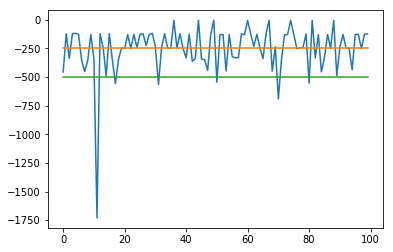

number of episodes more than -500: 94


In [9]:
import time

do_render = False
episodes = 100

s_record = []
a_record = []
r_record = []
sne_record = []

for i in range(episodes):
    
    s=env.reset()
    done = False
    
    s_r = []
    a_r = []
    r_r = []
    sne_r = []
   
    while not done:        
        if do_render:
            env.render()
#             time.sleep(0.016)
        s=np.array(s).reshape(1,-1)
        s_idx,_= state_cont2dis(s, dis_states1, dis_states2, possible_states)
        a=policy[s_idx]
        
        s_r.append(s)
        a_r.append(a)           
        
        s,r,done,info=env.step(a)
        
        sne_r.append(s)
        r_r.append(r)        
    s_record.append(s_r)
    a_record.append(a_r)
    sne_record.append(sne_r)
    r_record.append(r_r)
env.close()

r_record = np.array(r_record)
assert r_record.shape[0] == episodes
cumu_r = np.sum(r_record, axis=1)


plt.plot(cumu_r)
plt.plot( [np.mean(cumu_r)]*episodes )
plt.plot( [-500]*episodes )

plt.show()
print("number of episodes more than -500:", np.count_nonzero(cumu_r>-500.))

###  Maybe dimension have some minor problem, but it's the picture of the policy plot

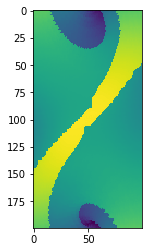

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()

y = dis_states1
x = dis_states2
z = V.reshape(dis_states1.shape[0], -1)


im = plt.imshow(z, animated=True)


def updatefig(*args):
    global x, y
    
    im.set_array(z)
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
plt.show()